In [ ]:
import sklearn.metrics
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical
from tensorflow.keras import models
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
data_folder = '/gdrive/MyDrive/Personal/ATLAS/final/data/'
models_folder = '/gdrive/MyDrive/Personal/ATLAS/final/models/'

Mounted at /gdrive


### Download Pre-processed data and prepare it for CNN

In [ ]:
X_test = pd.read_pickle(data_folder + "X_test.pkl")
Y_test_all = pd.read_pickle(data_folder + "Y_test_all.pkl")

In [ ]:
def process_data_for_cnn(X_test, Y_test_all):
    samples = X_test.count()[0]
    dfs = np.split(X_test, [9,45,81,90], axis=1)
    EM0=dfs[0]; EM1=dfs[1]; EM2=dfs[2]; EM3=dfs[3]; HAD=dfs[4]

    EM0 = EM0[np.repeat(EM0.columns.values,4)].to_numpy()
    EM1 = EM1.to_numpy()
    EM2 = EM2.to_numpy()
    EM3 = EM3[np.repeat(EM3.columns.values,4)].to_numpy()
    HAD = HAD[np.repeat(HAD.columns.values,4)].to_numpy()

    x = np.concatenate([EM0, EM1, EM2, EM3, HAD], axis=1)
    x = np.reshape(x, (samples, 5, 3, 12))
    y = to_categorical(Y_test_all['signal'], num_classes=2)
    pt = Y_test_all['truth_pt']

    return x, y, pt

In [ ]:
def process_data_for_fc(X_test, Y_test_all):
    x = X_test.to_numpy()
    y = to_categorical(Y_test_all['signal'], num_classes=2)
    pt = Y_test_all['truth_pt'].to_numpy()
    
    return x, y, pt

### Load models, evaluate and plot:

In [ ]:
y_predict_all = {}

for model_name in ['FC', 'LeNet', 'ResNet']:
    loaded_model = models.load_model(models_folder + f"{model_name}.h5")
    loaded_model.load_weights(models_folder + f'{model_name}.weights.best.hdf5')

    if model_name == "ResNet":
        x, y, pt = process_data_for_cnn(X_test, Y_test_all)
        x = np.rollaxis(x, 1, 4)
    elif model_name == "LeNet":
        x, y, pt = process_data_for_cnn(X_test, Y_test_all)
    elif model_name == "FC":
        x, y, pt = process_data_for_fc(X_test, Y_test_all)

    score_train = loaded_model.evaluate(x, y, verbose=0)
    print(f'Test score for {model_name} is {score_train}')

    y_predict_all[model_name] = loaded_model.predict(x)

Test score for FC is [0.4196977913379669, 0.7939298152923584, 0.8858305811882019]
Test score for LeNet is [0.41265979409217834, 0.8002347350120544, 0.8902767300605774]
Test score for ResNet is [0.4031786322593689, 0.8042469620704651, 0.8951590657234192]


### Create ROC Curves:

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, th = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100.5])
    plt.ylim([-0.5,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.legend()
    return fp, tp, th, ax

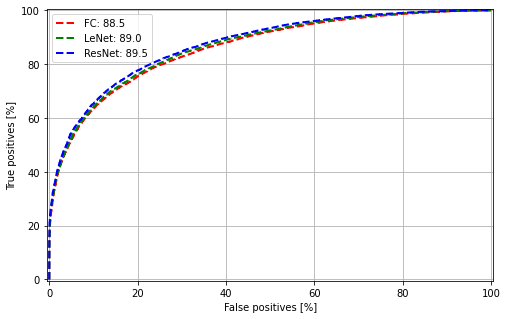

In [ ]:
colors = ['r', 'g', 'b']
aucs = [0.885, 0.89, 0.895]
i = 0
plt.figure(figsize=(8, 5))
for model_name in ['FC', 'LeNet', 'ResNet']:
    y_predict = y_predict_all[model_name]
    true_labels = y.argmax(axis=1)
    signal_score = y_predict[:, 1]
    fp, tp, thresholds, ax = plot_roc(model_name + f": {100*aucs[i]}", true_labels,
                                      signal_score, color=colors[i], linestyle='--')
    i+=1

### Plot the Training Process:

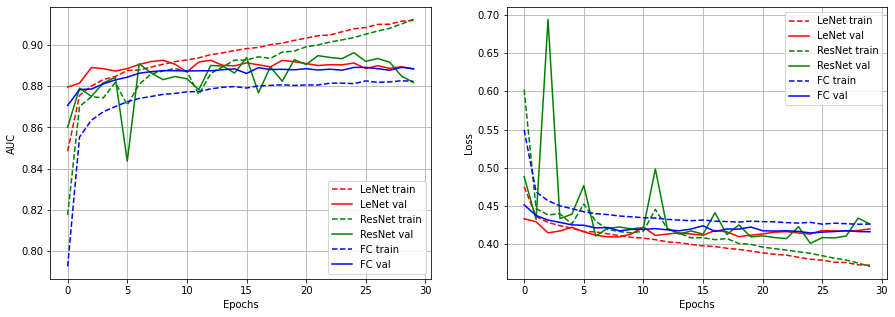

In [ ]:
%matplotlib inline
colors = ['r', 'g', 'b']
i = 0

fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(15,5))

for model_name in {'FC', 'LeNet', 'ResNet'}:

    history = pd.read_pickle(models_folder + f"{model_name}_history.pkl")

    ax1.plot(history['auc'], color=colors[i], linestyle='--', label=f"{model_name} train")
    ax1.plot(history['val_auc'], color=colors[i], label=f"{model_name} val")
    ax1.grid(True)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('AUC')
    ax1.legend()

    ax2.plot(history['loss'], color=colors[i], linestyle='--', label=f"{model_name} train")
    ax2.plot(history['val_loss'], color=colors[i], label=f"{model_name} val")
    ax2.grid(True)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    i+=1

### Evaluate Efficiency vs. Pt

In [ ]:
def calculate_efficiency(true_labels, TP, FP):

    TOTAL_REAL_POSITIVE = sum(true_labels)
    TOTAL_REAL_NEGATIVE = len(true_labels) - sum(true_labels)

    TOTAL_PRED_POSITIVE = sum(final_label)
    TOTAL_PRED_NEGATIVE = len(final_label) - sum(final_label)

    FN = TOTAL_REAL_POSITIVE - TP
    TN = TOTAL_REAL_NEGATIVE - FP

    Sensitivity = (TP/(TP+FN))
    Specificity = (TN/(TN+FP))
    Accuracy = ((TP+TN)/(TP+TN+FP+FN))
    Efficiency = ( Sensitivity + Specificity + Accuracy ) / 3

    return Specificity

In [ ]:
for cur_pt in range(10, 70, 10):
    pt_index = (pt[:]>=cur_pt) & (pt[:]<cur_pt+10)
    cur_true_labels = true_labels[pt_index]
    cur_signal_score = signal_score[pt_index]
    print(len(cur_true_labels))

    fp, tp, th = sklearn.metrics.roc_curve(cur_true_labels, cur_signal_score)

    index_th = np.max(np.where(fp<0.1))
    FP = fp[index_th]
    TP = tp[index_th]
    print(f'TP:{TP}, FP: {FP}')

    cur_eff = calculate_efficiency(cur_true_labels, TP, FP)
    print(f'Efficiency:{cur_eff}')

15419
TP:0.7706405371076029, FP: 0.09911182882519176


NameError: ignored

In [ ]:
TOTAL_REAL_POSITIVE = sum(true_labels)
TOTAL_REAL_NEGATIVE = len(true_labels) - sum(true_labels)
print(f"Real Data: {TOTAL_REAL_POSITIVE} total positive and {TOTAL_REAL_NEGATIVE} total negative samples")

In [ ]:
TOTAL_PRED_POSITIVE = sum(final_label)
TOTAL_PRED_NEGATIVE = len(final_label) - sum(final_label)
print(f"Predicted: {TOTAL_PRED_POSITIVE} total positive and {TOTAL_PRED_NEGATIVE} total negative samples")